# Forecasting Non-Farm Payrolls With Linear Regression

by [Manuel Perez Yllan](https://www.linkedin.com/in/mpyllan/)

<img width=80 src="Images/Assembler.png">

***

Because of its simplicity and outcomes that are linearly dependent, linear regression is ignored. Linear regression is a powerful tool for handling many challenging forecasting problems. Let’s see how to forecast employment data from the United States using a simple linear regression in Python.

<img width=800 src="Images/linear-regression.png">


## What Are Non-Farm Payrolls?
From all health of the labor market indicators in the United States, non-farm payrolls (NFP) is a crucial and frequently followed economic indicator. This monthly employment report, which does not include occupations in private households, NGOs, or the agricultural sector, offers a thorough overview of the employment situation in the United States. The NFP report reveals the net change in the total number of paid employees in the U.S., excluding the sectors mentioned above, in the previous month.

By analyzing the data, many people (economists, policymakers, and investors) can measure the health of the labor market, track employment trends, and make informed decisions regarding economic policies, investments, and hiring practices.

Let’s try to apply our model and see how it performs. We will evaluate our forecasts using the directional ratio and the RMSE. Here’s what they refer to:

- The directional ratio is simply a binary up or down measure that compares the number of the correct forecasts (NFP going up versus NFP going down) to the number of predictions.


- The RMSE stands for root mean squared error. It is a measure of the average magnitude of the errors between predicted and actual values in a dataset.

# Tasks
Linear regression draws the best-fitting straight line through a scatterplot of data points. 

1. Load the NFP data from the Excel file (NFP.xlsx). You can use the FRED API as well.

2. Split the data into training and test sets.

3. Fit the model using the last five NFP changes as features or signals. Predict the test set.

4. Evaluate and compare the performance of the predictions.

### Import Libraries

But first we need to load the required libraries:

In [1]:
# !pip install scikit-learn
# !pip install openpyxl
# !pip install matplotlib

# Required libraries
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Load and Transform the Data

Let's change the variable names to avoid overwriting data.

In [2]:
# Load data from file
data_raw = pd.read_excel('NFP.xlsx').values
# Is everything ok with the libraries?
print('Shape of data:', data_raw.shape)

Shape of data: (1010, 1)


We have to flatten the data. We need a list of numbers, not a list of lists.

In [6]:
# Flatten the data 
data_flatten = np.reshape(data_raw, (-1))
# What's np.reshape doing?
print('Shape of flatten data:', data_flatten.shape)
print('Sample:', data_flatten[:5])

Shape of flatten data: (1010,)
Sample: [ 180 -186  205  203  -83]


Now we want the "derivative" of the data. That is, the discrete rate of change from one point to the next.

In [8]:
# What's diff doing? Why?
data_derivative = np.diff(data_flatten)
print('Shape of the derivative data:', data_derivative.shape)
print('Sample:', data_derivative[:4])

Shape of the derivative data: (1009,)
Sample: [-366  391   -2 -286]


**Explanation:** `np.diff(data)` is a NumPy function used to compute the difference between each pair of adjacent elements in the array data. Specifically, for an input array `data = [a, b, c, d, ...]`, the output of `np.diff(data)` will be an array of differences `[b-a, c-b, d-c, ...]`.

Do you truly understand the data? Can you envision a plot for it?

Let's plot a sample with the first 50 values (49 for the 'derivative'):

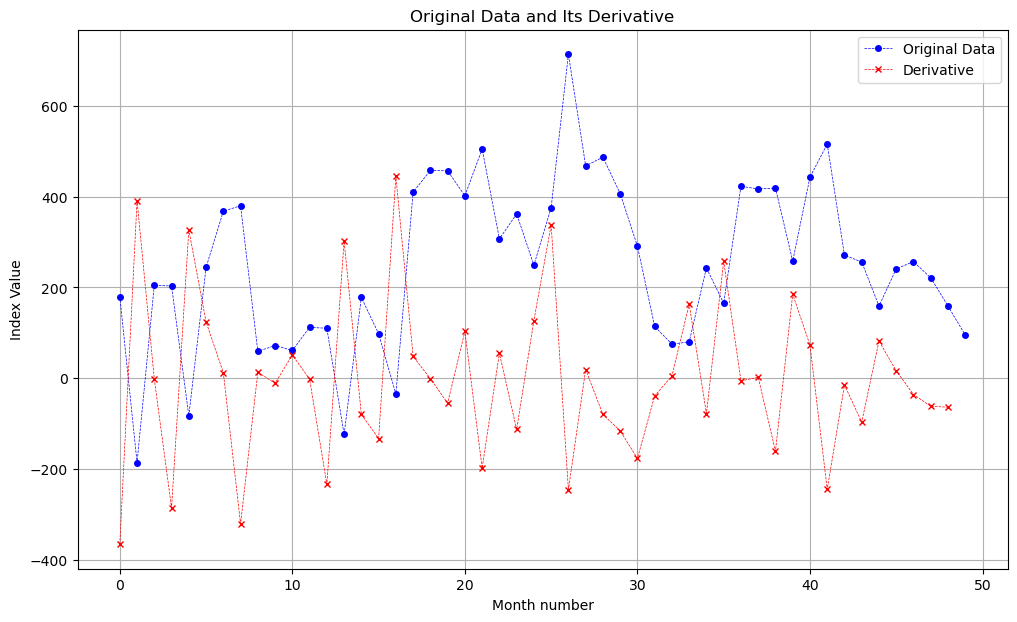

In [37]:
plt.figure(figsize=(12, 7))

# Plot original data
plt.plot(data_flatten[:50], marker='o', linestyle='--', color='blue', label='Original Data',
         linewidth=0.5, markersize=4)

# Plot derivative data
plt.plot(data_derivative[:49], marker='x', linestyle='--', color='red', label='Derivative',
         linewidth=0.5, markersize=4)

plt.title('Original Data and Its Derivative')
plt.xlabel('Month number')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

### Data Processing

Now we need to split the data into train and test sets. We`ll train the LR model over the train dataset and test its performance over the test dataset.
Let's define a function to split the data:

In [9]:
def data_preprocessing(data, num_lags, train_test_split):
    
    # Prepare the data for training
    x = []
    y = []
    for i in range(len(data) - num_lags):
        x.append(data[i:i + num_lags])
        y.append(data[i+ num_lags])
        # print(x)
        # print(y)
    
    # Convert the data to numpy arrays
    x = np.array(x)
    y = np.array(y)
    print('Data characterization:')
    print('x shape =', x.shape)
    print('y shape =', y.shape)
    
    # Split the data into training and testing setst
    split_index = int(train_test_split * len(x))
    _x_train = x[:split_index]
    _y_train = y[:split_index]
    _x_test = x[split_index:]
    _y_test = y[split_index:]

    return _x_train, _y_train, _x_test, _y_test 

**Exaplanation:** Craete input-output pairs (`x` and `y`)

`x` and `y` length: `len(data)` - `num_legs` = 1009 - 5 = 1004 arrays of 5 days each

**Example for the first iteration:** We store 5 items-sequances of length `num_legs` in the array `x` and the 6th value as output in `y`.

In [10]:
print(data_derivative[:5])
print(data_derivative[5])

[-366  391   -2 -286  327]
124


We repeat this procedure 1004-times. We obtain two sets with shapes:

- `x` shape = `(1004, 5)`

- `y` shape = `(1004,)`

`y` has the data predicted by the 5-previous-points in `x`.

In [14]:
# Datase preprocessing & Splitting
x_train, y_train, x_test, y_test = data_preprocessing(data_derivative, num_lags=5, train_test_split=0.80)

Data characterization:
x shape = (1004, 5)
y shape = (1004,)


After creating the input-output pairs, the data is split into **training and test sets**, allocating 80% of the data for training and reserving 20% for testing.

The math is as follows: 

- 1004*0.8 = 803.2  --> so we keep **803 samples** for the **training set**

- 1004 - 803 = 201  --> leaving **201 samples** for the **test set**

In [18]:
print('Training set size: x =', len(x_train), 'and y =', len(y_train))
print('Test set size: ', len(x_test))
print()
print(x_test)

Training set size: x = 803 and y = 803
Test set size:  201

[[   3 -138 -135   45  113]
 [-138 -135   45  113  -28]
 [-135   45  113  -28  -30]
 ...
 [-224  -31    0   64 -176]
 [ -31    0   64 -176  131]
 [   0   64 -176  131   -9]]


In [19]:
print('Test set objective set size:', len(y_test))
print()
print(y_test)

Test set objective set size: 201

[ -28  -30 -112  197  -37   39 -145  149 -165   88  -71 -109    5  111
  -15   47  -12 -105  -77    8 -149   26   33  -39  -86 -168  -13 -284
   51  -83   22  -60  150  313 -113  127  160  -59   62  175 -248  241
  -88  262   87  279 -674   63   85  -89  366 -147  -53  -74  203   15
  102 -227  132 -177   78   88   -9  -68   56  145  -73  -46 -143   25
  -36   74   31    5  -23    4   78  -51   89 -134   42   28  -37  -56
  122  -60   36   55 -221  130  -29  124   33 -109  129  -89  -61  123
  -63   42   -7  -81   71 -172  183   60 -183  139 -153   -6  185  -95
   48 -158   97   44  -66 -145  206  112 -214  148 -189   12   99   12
  -25  -76   67   20  -18  -15  -49  -43   56   82  -86    5  239 -165
  -78  184 -118 -155  194 -161   76  -69   87  126 -331  250   15 -176
  100  -85  150  -25  -78   86 -113  232  -61 1462 -774 -242 -455 -532
  762   81  209 -498  196  211   76 -106 -106  224 -167  -45 -205  540
 -490 -160  110    6  198 -216   -2  -26  -

### LR model

In [12]:
# Create a LR model
model = LinearRegression()

In [20]:
# Fit the model to the TRAIN!! data
model.fit(x_train, y_train)

LinearRegression()

In [21]:
# Predict on the TEST!! data.
y_pred = model.predict(x_test)  # Use X, not X_new for prediction

#### Results

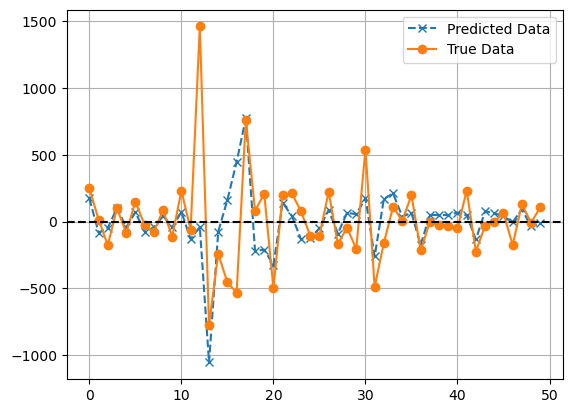

In [38]:
# Plot the original sine wave and the predicted values
plt.plot(y_pred[-50:], label='Predicted Data', linestyle='--', marker = 'x')
plt.plot(y_test[-50:], label='True Data', marker = 'o')
plt.legend()
plt.grid()
plt.axhline(y = 0, color = 'black', linestyle = '--')

#### RMSE discussion

The RMSE is a measure of the average magnitude of the errors between the values predicted by a model and the actual values observed. 

**Comparability:** Because RMSE is in the same units as the target variable, it allows for a more straightforward comparison of error magnitudes across different models or prediction tasks.

**Interpretation:** A lower RMSE value indicates a model that generally predicts more closely to the actual values, while a higher RMSE indicates larger discrepancies between predictions and actual values.

In [23]:
# RMSE Calculation
rmse_test = math.sqrt(mean_squared_error(y_pred, y_test))
print(f"RMSE of Test: {rmse_test}")
# Is this a good value for the error? Why?

RMSE of Test: 188.81346546125118


**Baseline Metric for RMSE:**  It sets a a simple but effective minimum performance threshold that any sophisticated model must exceed to be considered valuable.

**Mean Predictor:** The baseline RMSE is calculated using the mean of the actual values as a constant prediction, `y_test.mean()`. This offers a straightforward comparison to see if your model's predictions are, on average, closer to the actual values than simply guessing the average every time. It's useful for regression tasks where you're predicting a continuous value.

In [40]:
# Compute a simple baseline RMSE, using the mean of the actual values as constant prediction
baseline_preds = np.full(shape=y_test.shape, fill_value=y_test.mean())
baseline_rmse = np.sqrt(mean_squared_error(baseline_preds, y_test))
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 201.82749248885423


**Consider the Scale of the Data:** We calculate the range of the actual values (y_test). This gives us an idea of the overall variability and scale of the target variable, which is important for interpreting the RMSE.

In [42]:
# Consider the scale of the data
data_range = y_test.max() - y_test.min()
print(f"Data in [{y_test.min()};{y_test.max()}]")
print(f"Data Range: {data_range}")

Data in [-774;1462]
Data Range: 2236


**Evaluation:**

- **Comparison with Baseline Model:** We compare the model's RMSE to the baseline RMSE. If your model's RMSE is lower, it's performing better than a simple guess based on the average. This is a basic sanity check.

- **Percentage of Data Range:** We evaluate the RMSE as a percentage of the data range. This gives us an intuition about the error relative to the variability in the data. If the RMSE is a small fraction of the range (e.g., less than 10%), the model might be considered to perform well. The exact thresholds can vary depending on the problem domain and should be adjusted based on your requirements and the specific context of your application.

In [44]:
# Evaluation
print("Evaluation:")
if rmse_test < baseline_rmse:
    print("Your model performs better than the baseline model.")
else:
    print("Your model does not perform better than the baseline model. Consider improvements.")

if rmse_test / data_range < 0.1:
    print("RMSE is less than 10% of the data range. This is generally considered good.")
elif rmse_test / data_range < 0.2:
    print("RMSE is less than 20% of the data range. This may be acceptable depending on the application.")
else:
    print("RMSE is more than 20% of the data range. Consider this high depending on your application.")

Evaluation:
Your model performs better than the baseline model.
RMSE is less than 10% of the data range. This is generally considered good.


Yet, there are several other ways to evaluate the goodness of your RMSE value beyond comparing it to the data range and a baseline model, especially when predicting economic indicators like NFP. Here are some additional methods.

#### Directional ratio calculation

The directional ratio measures the percentage of times your model's predictions and the actual values (in this case, likely changes in NFP) move in the same direction. This metric doesn't consider the magnitude of the predictions or the actual values but rather focuses on the correctness of the direction of change (increase or decrease).

In [39]:
# Directional ratio calculation
same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_test)) / len(y_test) * 100
print('Directional Ratio = ', same_sign_count, '%')
# Is this a good ratio? Why?

Directional Ratio =  69.65174129353234 %


**Understanding the Directional Ratio**

**High Directional Ratio (>70-80%):** A high directional ratio suggests that your model is quite good at predicting the direction of change in the target variable. In contexts where the direction of change is more critical than the exact magnitude (such as in certain financial or economic forecasting scenarios), a high directional ratio can be very valuable. For example, knowing whether the NFP is going to increase or decrease can significantly impact economic policy decisions, market expectations, and investment strategies, even if the exact change is not perfectly predicted.

**Moderate Directional Ratio (50-70%):** A moderate directional ratio indicates that your model has some ability to predict the direction of change, but it might not be reliable enough for making critical decisions without additional information or analysis. In this range, the model performs better than random guessing but shows room for improvement.

**Low Directional Ratio (<50%):** A low directional ratio suggests that the model's predictions are often wrong regarding the direction of change. This performance might not be much better than flipping a coin in binary situations (increase or decrease). It indicates a need for model reassessment, feature engineering, or considering non-linear relationships that might better capture the dynamics of the target variable.

<br>

To conclude,

**Complementary Metric:** The directional ratio should be considered alongside other performance metrics (like RMSE, MAE, or economic significance measures) to get a comprehensive view of your model's performance. While getting the direction right is valuable, understanding the magnitude of change is also crucial for many applications.